# Summary

   Firstly, I did brief look at outliers and preprocess, and I made base matrix dataframe for being able to merge other dataframes.
About feat engineering, I added lag feat, mean encoding and trend feat. My challenging was making general function to make these features easy later.
    Before modeling, I dropped 0～11 monthes data, because they were used for lag feat.
    In Model phase, I used LightGBM and simple linear model. About validation, I took kind of TimeSeriesSplit. That is, first 12～27 monthes are mainly used for training, 28～33 monthes for valid.
    After that, I tried simple convex mix and stacking, which is part of assignment in this course.

# Code

From the beginning to the end, it takes about 90 mins (86 mins)

In [2]:
import time
start = time.time()

In [3]:
# I put each version here
# python version is 3.7.3

import numpy as np     # 1.16.4
from matplotlib import pyplot as plt # 3.1.0
import seaborn as sns  # 0.9.0
import pandas as pd    # 0.25.0

# sklearn is 0.21.2
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# lgbm is 2.2.3
import lightgbm as lgb 
from lightgbm import plot_importance

from itertools import product
import gc, warnings, pickle, time
from pathlib import Path

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)

In [5]:
# This process makes it easy to read csv in next cell
Path.ls = lambda x: list(x.iterdir())
path = Path('D:/data/final_pj/csvfiles')
for i, p in enumerate(path.ls()):
    print(i, str(p).split('\\')[-1])

0 items.csv
1 item_categories.csv
2 sales_train.csv
3 sample_submission.csv
4 shops.csv
5 test.csv


In [6]:
items = pd.read_csv(path.ls()[0])
cats  = pd.read_csv(path.ls()[1])
train = pd.read_csv(path.ls()[2])
sub   = pd.read_csv(path.ls()[3])
shops = pd.read_csv(path.ls()[4])
test  = pd.read_csv(path.ls()[5]).set_index('ID')

In [7]:
train.date = pd.to_datetime(train.date, format='%d.%m.%Y')

In [8]:
train[:2]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.0,1.0
1,2013-01-03,0,25,2552,899.0,1.0


## outliers

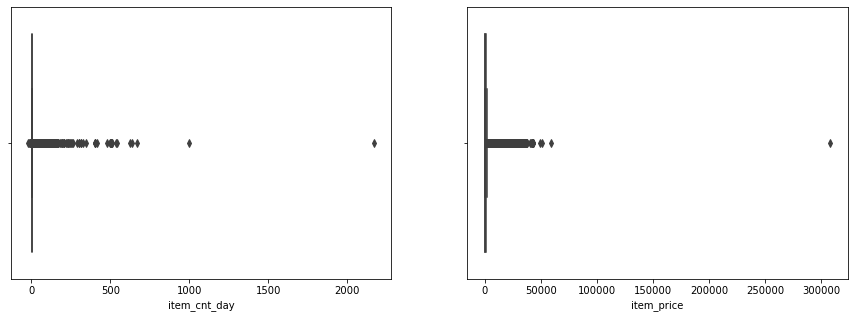

In [9]:
_, ax = plt.subplots(1,2, figsize=(15,5))
sns.boxplot(train.item_cnt_day, ax=ax[0])
sns.boxplot(train.item_price, ax=ax[1]);

In [10]:
# remove outliers
train = train[train.item_cnt_day<1001]
train = train[train.item_price<100000]

In [11]:
# Check irregular price and fill median value
train[train.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [12]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

In [13]:
# There are shops whose name is almost identical.
# I see them as same one

# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [14]:
np.sort(train.shop_id.unique())

array([ 2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59], dtype=int64)

## Shops

In [15]:
shops[:2]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1


In [16]:
# Simple splitting
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

In [17]:
shops[:2]

,shop_id,city_code
0,0,29
1,1,29


## Cats

In [18]:
cats[:2]

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1


In [19]:
# Similarly, splitting and encoding
cats['split'] = cats.item_category_name.str.split('-')
cats['type']  = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
cats['subtype']  = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])

cats = cats[['item_category_id','type_code', 'subtype_code']]

In [20]:
cats[:2]

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9


In [21]:
items[:2]

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76


In [22]:
# I cannot see analogy, so just drop
items.drop(['item_name'], 1, inplace=True)

## Monthly sales

In [23]:
# This task requires monthly sales of each item at each shop.
# make base dataframe, and merge other dataframe into this base one

matrix = []
cols = ['date_block_num', 'shop_id', 'item_id']
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append(np.array(list(product([i], sales['shop_id'].unique(), sales['item_id'].unique()))))

matrix = pd.DataFrame(np.vstack(matrix), columns=cols, dtype=np.int16).sort_values(cols).reset_index(drop=True)
matrix.date_block_num = matrix.date_block_num.astype(np.int8)
matrix.shop_id        = matrix.shop_id.astype(np.int8)

In [24]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [25]:
# train df has 'item_cnt_day' feat
# So group by 'month', 'shop' and 'item' to calculate monthly sale
# and merge into base matrix

grp = train.groupby(cols).agg(item_cnt_month=('item_cnt_day', 'sum')).reset_index()
matrix = matrix.merge(grp, 'left', cols)
matrix.item_cnt_month = matrix.item_cnt_month.fillna(0).clip(0,20).astype(np.float16)

## Test set

In [26]:
# In order to merge test into base matrix, make month data into test df

test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols).fillna(0)

## Concat df

In [27]:
matrix = matrix.merge(shops, 'left', 'shop_id')
matrix = matrix.merge(items, 'left', 'item_id')
matrix = matrix.merge(cats , 'left', 'item_category_id')

matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)

In [28]:
matrix[:2]

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0,40,11,4
1,0,2,27,1.0,0,19,5,10


## Target lag

In [29]:
def lag_feat(df, lags, col):
    tmp = df[cols + [col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = cols + [col + '_lag_' + str(i)]
        shifted['date_block_num'] += i
        df = df.merge(shifted, 'left', cols)
    return df

In [30]:
ts = time.time()
matrix = lag_feat(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

27.992873191833496

In [31]:
gc.collect()

268

## Mean enc

Before encoding, I set up general function, because I want to avoid making same encoding code again and again.

In [32]:
def encoding(df, col, targ, stat, types=None, lags=None, drop=False, other_df=None, return_grp=False):
    col_name = col[0].split('_')[0]
    if len(col) > 1:
        for c in col[1:]:
            if 'cat' in c:
                col_name += '_cat'
                continue
            col_name += '_' + c.split('_')[0]
    col_name += '_' + stat + '_' + targ    
    
    if other_df is None  : grp = df.groupby(col).agg({targ:stat})
    else                 : grp = other_df.groupby(col).agg({targ:stat})
        
    grp.columns = [col_name]
    grp.reset_index(inplace=True)
        
    df = df.merge(grp, 'left', col)
    gc.collect()
    
    if types is not None: df[col_name] = df[col_name].astype(types)
    if lags  is not None:
        df = lag_feat(df, lags, col_name)
        if drop:
            df.drop(col_name, 1, inplace=True)
            
    if return_grp: return df, grp
    
    return df

In [33]:
matrix[:2]

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN


In [34]:
ts = time.time()

matrix = encoding(matrix, ['date_block_num'], 'item_cnt_month', 'mean', np.float16, [1], True)
matrix = encoding(matrix, ['date_block_num', 'item_id'], 'item_cnt_month', 'mean', np.float16, [1,2,3,6,12], True)
matrix = encoding(matrix, ['date_block_num', 'shop_id'], 'item_cnt_month', 'mean', np.float16, [1,2,3,6,12], True)
matrix = encoding(matrix, ['date_block_num', 'item_category_id'], 'item_cnt_month', 'mean', np.float16, [1], True)
matrix = encoding(matrix, ['date_block_num', 'shop_id', 'item_category_id'], 'item_cnt_month', 'mean', np.float16, [1], True)
matrix = encoding(matrix, ['date_block_num', 'shop_id', 'type_code'], 'item_cnt_month', 'mean', np.float16, [1], True)
matrix = encoding(matrix, ['date_block_num', 'shop_id', 'subtype_code'], 'item_cnt_month', 'mean', np.float16, [1], True)
matrix = encoding(matrix, ['date_block_num', 'city_code'], 'item_cnt_month', 'mean', np.float16, [1], True)
matrix = encoding(matrix, ['date_block_num', 'item_id', 'city_code'], 'item_cnt_month', 'mean', np.float16, [1], True)
matrix = encoding(matrix, ['date_block_num', 'type_code'], 'item_cnt_month', 'mean', np.float16, [1], True)
matrix = encoding(matrix, ['date_block_num', 'subtype_code'], 'item_cnt_month', 'mean', np.float16, [1], True)

time.time() - ts

174.97405076026917

## Trend feat

Price trend for the last (six) month: Item price in last month (or more before) is more expensive or cheaper than mean

In [35]:
ts = time.time()
matrix = encoding(matrix, ['item_id'], 'item_price', 'mean', np.float16, other_df=train)
matrix = encoding(matrix, ['date_block_num','item_id'], 'item_price', 'mean', np.float16, [1,2,3,4,5,6], other_df=train)
time.time() - ts

45.23768210411072

In [36]:
# delta = item_price_(lag) - mean of price / mean of price
# -> if delta > 0: particular time block's price is more expensive than mean
#            else: mean is more expensive


lags = [1,2,3,4,5,6]
for i in lags:
    matrix['delta_price_lag_' + str(i)] = \
        (matrix['date_item_mean_item_price_lag_' + str(i)] - matrix['item_mean_item_price']) / matrix['item_mean_item_price']
time.time() - ts

46.35768389701843

In [37]:
# This answers "Have the item become cheaper or more expensive from mean of entire month"
def select_trend(row):
    for i in lags:
        if not np.isnan(row['delta_price_lag_' + str(i)]):
            return row['delta_price_lag_' + str(i)]
    return 0

In [38]:
ts = time.time()
zero_bool = matrix[[c for c in matrix if 'delta_price_lag' in c]].sum(1).astype(bool)
matrix['delta_price_lag'] = matrix[zero_bool][[c for c in matrix if 'delta_price_lag' in c]].apply(select_trend, 1).astype(np.float16).fillna(0)
time.time() - ts

169.59054923057556

In [39]:
matrix[:2]

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_mean_item_cnt_month_lag_1,date_item_mean_item_cnt_month_lag_1,date_item_mean_item_cnt_month_lag_2,date_item_mean_item_cnt_month_lag_3,date_item_mean_item_cnt_month_lag_6,date_item_mean_item_cnt_month_lag_12,date_shop_mean_item_cnt_month_lag_1,date_shop_mean_item_cnt_month_lag_2,date_shop_mean_item_cnt_month_lag_3,date_shop_mean_item_cnt_month_lag_6,date_shop_mean_item_cnt_month_lag_12,date_cat_mean_item_cnt_month_lag_1,date_shop_cat_mean_item_cnt_month_lag_1,date_shop_type_mean_item_cnt_month_lag_1,date_shop_subtype_mean_item_cnt_month_lag_1,date_city_mean_item_cnt_month_lag_1,date_item_city_mean_item_cnt_month_lag_1,date_type_mean_item_cnt_month_lag_1,date_subtype_mean_item_cnt_month_lag_1,item_mean_item_price,date_item_mean_item_price,date_item_mean_item_price_lag_1,date_item_mean_item_price_lag_2,date_item_mean_item_price_lag_3,date_item_mean_item_price_lag_4,date_item_mean_item_price_lag_5,date_item_mean_item_price_lag_6,delta_price_lag_1,delta_price_lag_2,delta_price_lag_3,delta_price_lag_4,delta_price_lag_5,delta_price_lag_6,delta_price_lag
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1461.0,2324.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
feat_to_drop = ['item_mean_item_price', 'date_item_mean_item_price']
for i in lags:
    feat_to_drop += ['date_item_mean_item_price_lag_' + str(i)] + ['delta_price_lag_' + str(i)]

matrix.drop(feat_to_drop, 1, inplace=True)

In [41]:
matrix[:2]

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_mean_item_cnt_month_lag_1,date_item_mean_item_cnt_month_lag_1,date_item_mean_item_cnt_month_lag_2,date_item_mean_item_cnt_month_lag_3,date_item_mean_item_cnt_month_lag_6,date_item_mean_item_cnt_month_lag_12,date_shop_mean_item_cnt_month_lag_1,date_shop_mean_item_cnt_month_lag_2,date_shop_mean_item_cnt_month_lag_3,date_shop_mean_item_cnt_month_lag_6,date_shop_mean_item_cnt_month_lag_12,date_cat_mean_item_cnt_month_lag_1,date_shop_cat_mean_item_cnt_month_lag_1,date_shop_type_mean_item_cnt_month_lag_1,date_shop_subtype_mean_item_cnt_month_lag_1,date_city_mean_item_cnt_month_lag_1,date_item_city_mean_item_cnt_month_lag_1,date_type_mean_item_cnt_month_lag_1,date_subtype_mean_item_cnt_month_lag_1,delta_price_lag
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Last month shop revenue trend: Revenue at the shop in last month is better than mean revenue or not.

In [42]:
ts = time.time()

matrix, group = encoding(matrix, ['date_block_num','shop_id'], 'revenue', 'sum', np.float32, other_df=train, return_grp=True)
matrix = encoding(matrix, ['shop_id'], 'date_shop_sum_revenue', 'mean', np.float32, other_df=group)

matrix['delta_revenue'] = (matrix['date_shop_sum_revenue'] - matrix['shop_mean_date_shop_sum_revenue']) / matrix['shop_mean_date_shop_sum_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feat(matrix, [1], 'delta_revenue')
matrix.drop(['date_shop_sum_revenue','shop_mean_date_shop_sum_revenue','delta_revenue'], 1, inplace=True)

time.time() - ts

14.289753437042236

## Other elapsed feat

In [43]:
matrix['month'] = matrix['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

Months since the last sale for each shop/item pair and for item only.

In [44]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)

key = (matrix.item_id.astype(str) + ' ' + matrix.shop_id.astype(str)).values
item_cnt_month = matrix.item_cnt_month.values
date_block_num = matrix.date_block_num.values
for i, k in enumerate(key):
    if k not in cache:
        if item_cnt_month[i] != 0:
            cache[k] = date_block_num[i]
    else:
        matrix.at[i, 'item_shop_last_sale'] = date_block_num[i] - cache[k]
        cache[k] = date_block_num[i]
    
time.time() - ts

115.0364043712616

In [45]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)

key = matrix.item_id.values
for i, k in enumerate(key):
    if k not in cache:
        if item_cnt_month[i] != 0:
            cache[k] = date_block_num[i]
    else:
        matrix.at[i, 'item_last_sale'] = date_block_num[i] - cache[k]
        cache[k] = date_block_num[i]

time.time() - ts

187.81189823150635

Months since the first sale for each shop/item pair and for item only.

In [46]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

2.3243303298950195

## Final prep

Drop first 12 months because of using them as time lag values.

In [47]:
matrix = matrix[matrix.date_block_num > 11]

In [48]:
matrix[[c for c in matrix if '_lag_' in c and 'item_cnt' in c]][:3]

,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12,date_mean_item_cnt_month_lag_1,date_item_mean_item_cnt_month_lag_1,date_item_mean_item_cnt_month_lag_2,date_item_mean_item_cnt_month_lag_3,date_item_mean_item_cnt_month_lag_6,date_item_mean_item_cnt_month_lag_12,date_shop_mean_item_cnt_month_lag_1,date_shop_mean_item_cnt_month_lag_2,date_shop_mean_item_cnt_month_lag_3,date_shop_mean_item_cnt_month_lag_6,date_shop_mean_item_cnt_month_lag_12,date_cat_mean_item_cnt_month_lag_1,date_shop_cat_mean_item_cnt_month_lag_1,date_shop_type_mean_item_cnt_month_lag_1,date_shop_subtype_mean_item_cnt_month_lag_1,date_city_mean_item_cnt_month_lag_1,date_item_city_mean_item_cnt_month_lag_1,date_type_mean_item_cnt_month_lag_1,date_subtype_mean_item_cnt_month_lag_1
4488710,0.0,0.0,0.0,0.0,1.0,0.411377,0.086975,0.044434,0.130493,0.065247,0.155518,0.148071,0.100647,0.08905,0.096008,0.141235,1.082031,0.955566,0.808594,0.935059,0.148071,0.0,1.03418,1.075195
4488711,0.0,0.0,0.0,0.0,NaN,0.411377,1.021484,1.022461,0.521973,0.891113,NaN,0.148071,0.100647,0.08905,0.096008,NaN,0.291504,0.046234,0.051727,0.046234,0.148071,0.0,0.27002,0.291504
4488712,0.0,0.0,0.0,0.0,NaN,0.411377,0.543457,0.600098,0.543457,0.304443,NaN,0.148071,0.100647,0.08905,0.096008,NaN,0.232788,0.059448,0.051727,0.064697,0.148071,0.0,0.27002,0.234009


In [49]:
matrix[[c for c in matrix if '_lag_' in c and 'item_cnt' in c]].isna().sum()

item_cnt_month_lag_1                           1397796
item_cnt_month_lag_2                           1604874
item_cnt_month_lag_3                           1808536
item_cnt_month_lag_6                           2382471
item_cnt_month_lag_12                          3499752
date_mean_item_cnt_month_lag_1                 1397796
date_item_mean_item_cnt_month_lag_1            1397796
date_item_mean_item_cnt_month_lag_2            1604874
date_item_mean_item_cnt_month_lag_3            1808536
date_item_mean_item_cnt_month_lag_6            2382471
date_item_mean_item_cnt_month_lag_12           3499752
date_shop_mean_item_cnt_month_lag_1            1397796
date_shop_mean_item_cnt_month_lag_2            1604874
date_shop_mean_item_cnt_month_lag_3            1808536
date_shop_mean_item_cnt_month_lag_6            2382471
date_shop_mean_item_cnt_month_lag_12           3499752
date_cat_mean_item_cnt_month_lag_1             1397796
date_shop_cat_mean_item_cnt_month_lag_1        1397796
date_shop_

In [50]:
# matrix.fillna(0,inplace=True) cannot be used
# because of price based columns (like delta_price_lag) which can not be filled with zeros.

ts = time.time()
def fill_na(df):
    for c in df[[c for c in df if '_lag_' in c and 'item_cnt' in c]]:
        if df[c].isnull().any():
            df[c].fillna(0, inplace=True)
    return df

matrix = fill_na(matrix)
time.time() - ts

0.8597066402435303

In [51]:
matrix.to_pickle('data_after_FE.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
gc.collect();

# First level model

In [52]:
data = pd.read_pickle('data_after_FE.pkl')

In [53]:
X_trn  = data[data.date_block_num <  34].drop('item_cnt_month', 1)
X_test = data[data.date_block_num == 34].drop('item_cnt_month', 1)

y_trn  = data[data.date_block_num <  34]['item_cnt_month']

### Test meta-feat

#### Linear Model

In [54]:
# NaN included columns
data[[c for c in data if data[c].isna().any()]].isna().sum()

delta_price_lag         994673
delta_revenue_lag_1    1397796
dtype: int64

In [55]:
# I want to avoid fillna something causes bad effect, and decide to drop NaN cols
use_cols_lr  = [c for c in data if 'lag' in c]
drop_cols_lr = [c for c in data if 'delta' in c]

X_trn_lr  = X_trn[use_cols_lr].drop(drop_cols_lr, 1)
X_test_lr = X_test[use_cols_lr].drop(drop_cols_lr, 1)

In [56]:
lr = LinearRegression()
lr.fit(X_trn_lr, y_trn)
pred_lr = lr.predict(X_test_lr)

#### LGBM

In [57]:
lgb_params = {
               'n_estimators':1000,
               'feature_fraction': 0.8,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**8, 
               'bagging_fraction': 0.8, 
               'learning_rate': 0.3, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':1,
               'seed':42
              }

In [58]:
ts = time.time()
model = lgb.train(lgb_params, lgb.Dataset(X_trn, y_trn))
time.time() - ts

618.1762793064117

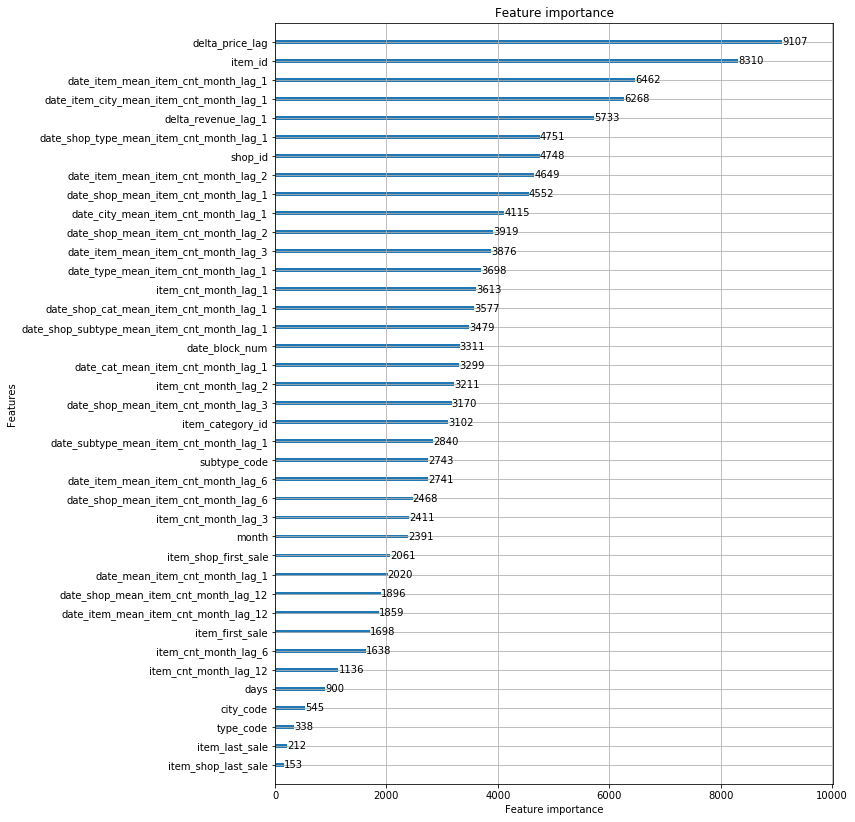

In [59]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14));

In [60]:
# drop worst 5 columns
drop_cols_lgb = X_trn.columns[model.feature_importance().argsort()[:5]]

X_trn_lgb  = X_trn.drop(drop_cols_lgb,  1)
X_test_lgb = X_test.drop(drop_cols_lgb, 1)

In [61]:
ts = time.time()
model = lgb.train(lgb_params, lgb.Dataset(X_trn_lgb, y_trn))
time.time() - ts

571.2265939712524

In [62]:
pred_lgb = model.predict(X_test_lgb)

In [63]:
# Test meta-feat
X_test_level2 = np.concatenate([pred_lr[:, None], pred_lgb[:, None]], 1)

### Train meta-feat

In [64]:
data.date_block_num.unique()

array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33, 34], dtype=int64)

In [65]:
ts = time.time()

lr_preds, lgb_preds = [], []

for n in list(range(28, 34)):
    ts_for = time.time()
    print(n)
    X_fit_lr   = X_trn_lr [data.date_block_num <  n]  # trn
    X_meta_lr  = X_trn_lr [data.date_block_num == n]  # val
    X_fit_lgb  = X_trn_lgb[data.date_block_num <  n]  # trn
    X_meta_lgb = X_trn_lgb[data.date_block_num == n]  # val
    y_fit      = y_trn    [data.date_block_num <  n]  # trn
    
    lr.fit(X_fit_lr, y_fit)
    lr_preds.append(lr.predict(X_meta_lr))
    lgb_preds.append(lgb.train(lgb_params, lgb.Dataset(X_fit_lgb, y_fit)).predict(X_meta_lgb))
    gc.collect()
    time.time() - ts_for
    
time.time() - ts

28
29
30
31
32
33


3142.4122405052185

In [66]:
X_train_level2 = np.concatenate([np.hstack(lr_preds)[:, None], np.hstack(lgb_preds)[:, None]], 1)

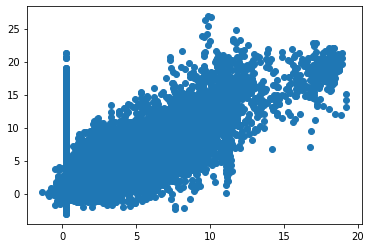

In [67]:
# I see wide distribution
plt.scatter(X_train_level2[:,0], X_train_level2[:,1]);

# Ensembling

## Simple convex mix

In [68]:
y_meta = y_trn[data.date_block_num.isin(list(range(28,34)))]

In [69]:
np.linspace(0,1,1001)

array([0.   , 0.001, 0.002, ..., 0.998, 0.999, 1.   ])

In [70]:
ts = time.time()
best_score = 0
for a in np.linspace(0,1,1001):
    if a * 1000 % 200 == 0: print(a)
    mix = a * X_train_level2[:,0] + (1-a) * X_train_level2[:,1]
    score = r2_score(y_meta, mix)
    if score > best_score:
        best_alpha = a
        best_score = score
time.time() - ts
        
print('Best alpha: {}  Best score: {}'.format(best_alpha, best_score))
# Even in RMSE, Best alpha becomes 0.493

0.0
0.2
0.4
0.6
0.8
1.0
Best alpha: 0.493  Best score: 0.427254543516989


In [71]:
sub.item_cnt_month = best_alpha * X_test_level2[:,0] + (1-best_alpha) * X_test_level2[:,1]

In [72]:
sub.to_csv('convexMix_lgb_lr.csv', index=False)

## Stacking

In [73]:
lr.fit(X_train_level2, y_meta)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [74]:
sub.item_cnt_month = lr.predict(X_test_level2)
sub.to_csv('stack_lgb_lr.csv', index=False)

Stacking (0.960848) got better score than convexMix (0.962145) in private LB.

In [75]:
time.time() - start

5209.984307050705